<a href="https://colab.research.google.com/github/decorouz/DeepLeaning-with-Tensorflow/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:

!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-5ldf_yfa
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-5ldf_yfa
  Resolved https://github.com/tensorflow/examples.git to commit 1c1d108deea5519de0c6b1c69242b8512b36a086
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-1c1d108deea5519de0c6b1c69242b8512b36a086_-py3-none-any.whl size=299719 sha256=e7263c569746c57373673f3d45d7d5f07470894ab99d73d4294524cf677a9dc8
  Stored in directory: /tmp/pip-ephem-wheel-cache-ibq4xwql/wheels/4e/f5/c2/bfe75b834c9028b2529023bf74541c46ead531b513a8010d21
Failed to build tensorflow-examples
  Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel c

In [19]:
## Setting up Google Drive to save datasets
from google.colab import drive
drive.mount("/content/gdrive")
root_path = 'gdrive/My Drive/Colab Notebooks/'



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [5]:
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt


### Download the Oxford-IIIT Pets dataset

In [6]:
dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteS66D4E/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteS66D4E/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [9]:
dataset

{'train': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [16]:
info.splits

{'train': <SplitInfo num_examples=3680, num_shards=4>,
 'test': <SplitInfo num_examples=3669, num_shards=4>}

In [27]:
dataset["train"]

<PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

Normalize the image value to the [0, 1] range. The pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [10]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [31]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint["image"], (128, 128))
  input_mask = tf.image.resize(
      datapoint["segmentation_mask"], 
      (128,128),
      method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  input_image,input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

In [32]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [33]:
train_images = dataset["train"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

Perform a simple Augmentation.

In [40]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=43):
    super().__init__()

    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_inputs(labels)
    return inputs, labels


Build the pipeline, applying augmentation after batching

In [41]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

Visualize an image example and its corresponding mask from the dataset

In [45]:
def display(display_list):
  plt.figure(figsize=(15,15))

  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

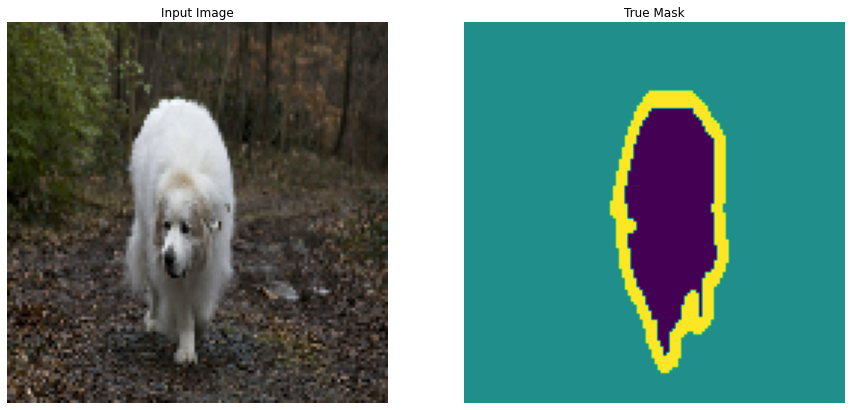

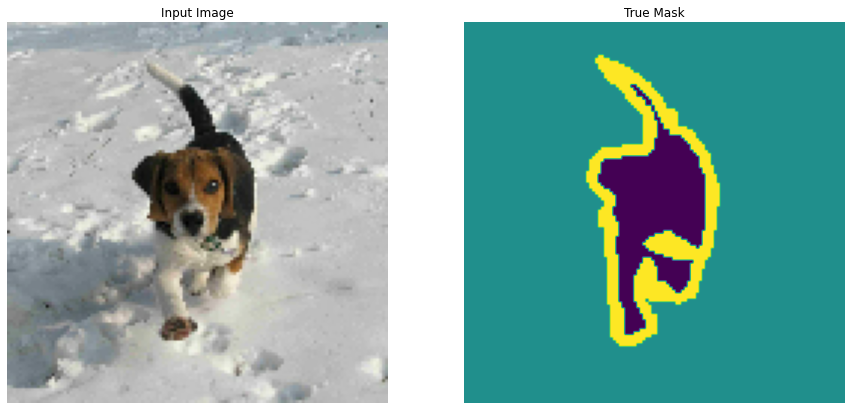

In [48]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image,sample_mask ])


## Define the Model

The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). To learn robust features and reduce the number of trainable parameters, use a pretrained model—[MobileNetV2](https://arxiv.org/abs/1801.04381)—as the encoder. 
For the decoder, you will use the upsample block, which is already implemented in the pix2pix 

In [51]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128,128,3], include_top=False)

# Layers whose activation is to be used
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model 
down_stack = tf.keras.Model(inputs=base_model.input, outputs = base_model_outputs)

down_stack.trainable = False

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples:

In [52]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [80]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128,128, 3])

  # Downsampling through the model 
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])
  print(skips)
  print(up_stack)

  # unsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters = output_channels,
      kernel_size = 3,
      strides = 2,
      padding = "same"
  ) #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x) #Indicating one output per class



## Train the model

Compile and train the model.
Since this is a multiclass problem, use the [tf.keras.losses.CategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) loss function with `from_logits` arguement set to `True`,  since the labels are scalar integers instead of vectors of scores for each pixel of every class.

When running inference, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

In [104]:
OUTPUT_CLASSES = 3
model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])


[<keras.engine.sequential.Sequential object at 0x7fa96613a670>, <keras.engine.sequential.Sequential object at 0x7fa931a64580>, <keras.engine.sequential.Sequential object at 0x7fa94e2b3af0>, <keras.engine.sequential.Sequential object at 0x7fa94e2862e0>]


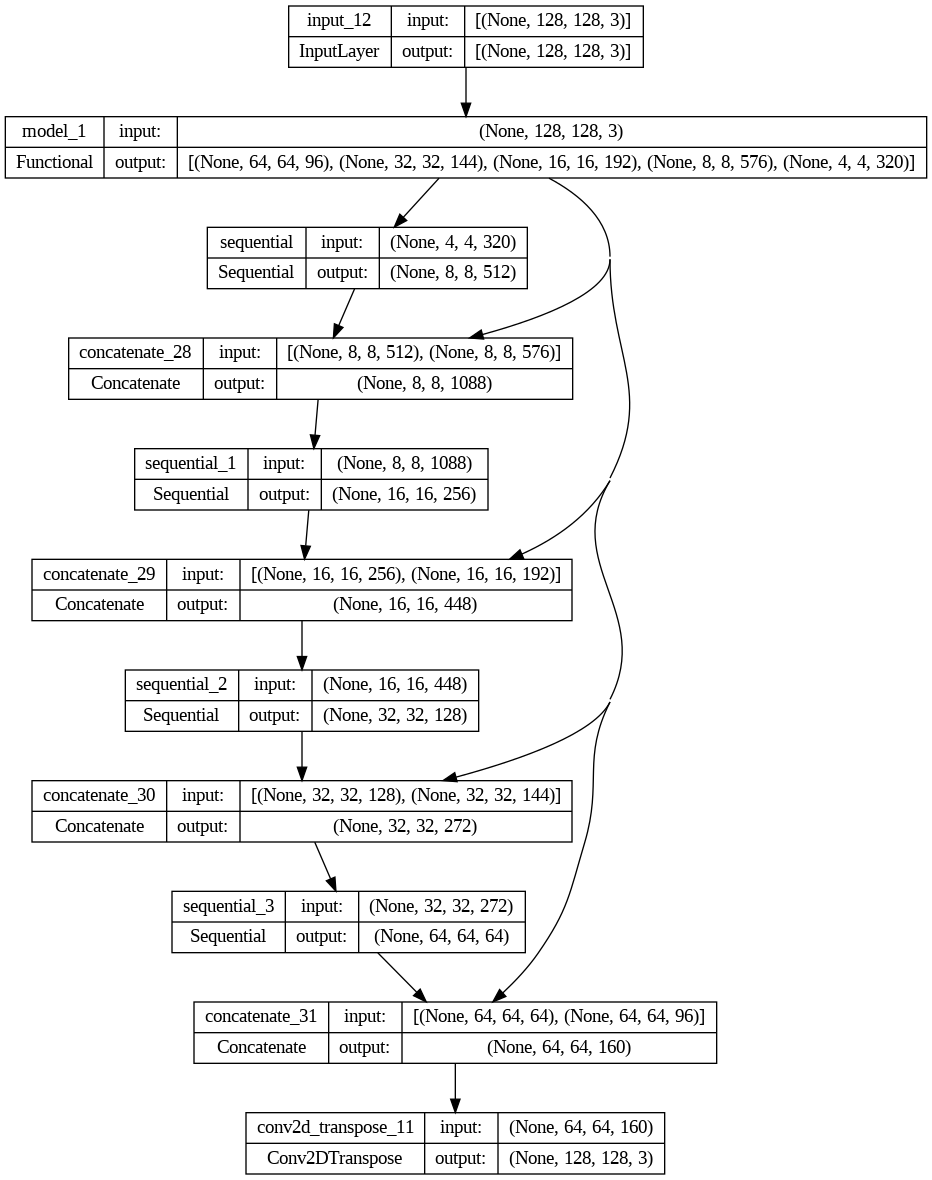

In [106]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [107]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[...,tf.newaxis]
  return pred_mask[0]

In [108]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 868ms/step


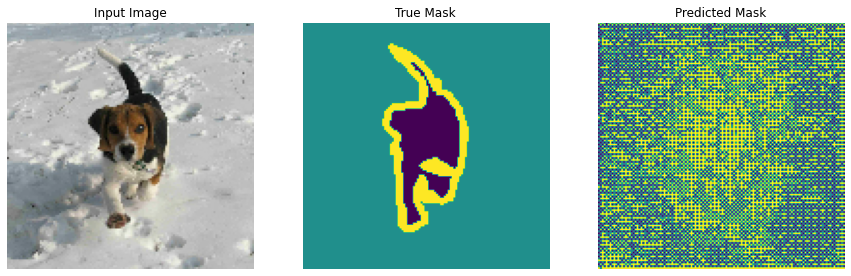

In [109]:
show_predictions()

The calllback is used to observed how the model improves while training 

In [110]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 42ms/step


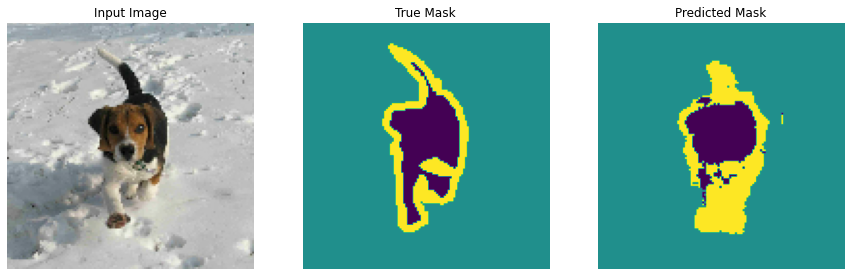


Sample Prediction after epoch 20

57/57 [==============================] - 11s 196ms/step - loss: 0.4486 - accuracy: 0.8087 - val_loss: 0.3882 - val_accuracy: 0.8634


In [111]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

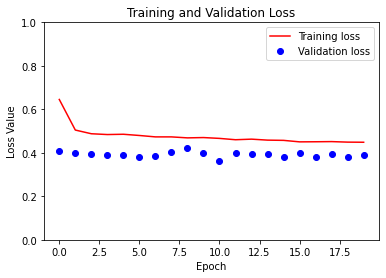

In [112]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make predictions
Now, make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

2/2 [==============================] - 0s 56ms/step


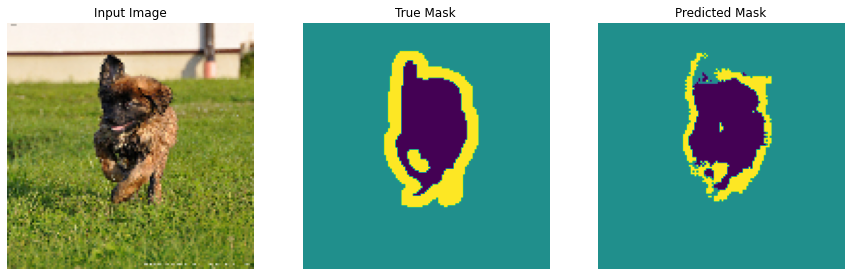

2/2 [==============================] - 0s 50ms/step


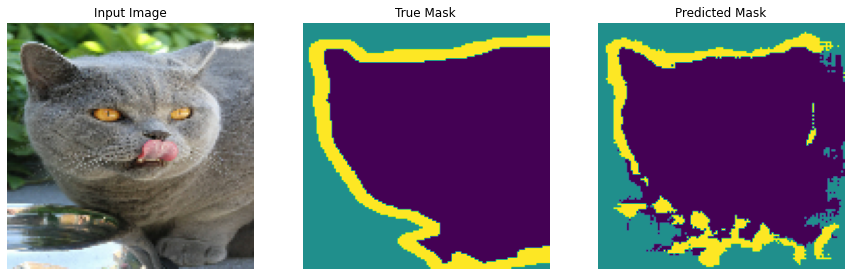

2/2 [==============================] - 0s 53ms/step


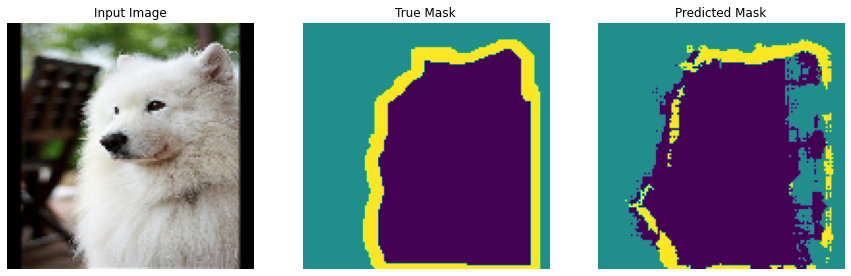

In [114]:
show_predictions(test_batches, 3)

## Imbalanced classes and class weights

In [115]:
try:
  model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

Expected ValueError: `class_weight` not supported for 3+ dimensional targets.


Using sample weights: In addition to (data, label) pairs, Model.fit also accepts (data, label, sample_weight) triples.

Keras Model.fit propagates the sample_weight to the losses and metrics, which also accept a sample_weight argument. The sample weight is multiplied by the sample's value before the reduction step. For example:

In [116]:
label = [0,0]
prediction = [[-3., 0], [-3, 0]] 
sample_weight = [1, 10] 

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                               reduction=tf.keras.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

array([ 3.0485873, 30.485874 ], dtype=float32)

In [117]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([2.0, 2.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [118]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

In [119]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

[<keras.engine.sequential.Sequential object at 0x7fa96613a670>, <keras.engine.sequential.Sequential object at 0x7fa931a64580>, <keras.engine.sequential.Sequential object at 0x7fa94e2b3af0>, <keras.engine.sequential.Sequential object at 0x7fa94e2862e0>]


In [120]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)

10/10 [==============================] - 5s 160ms/step - loss: 0.3441 - accuracy: 0.5717
